In [ ]:
# Libraries to install - leave this code block blank if this does not apply to you
# Please add a brief comment on why you need the library and what it does

# these imports are necessary for processing the WAV audio files and create spectrograms
from torchaudio.utils import download_asset
import torchaudio
import torchaudio.transforms as T

# needed for the SVM model
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

import math

In [ ]:
# Libraries you might need
# General
import os
import zipfile
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# For preproccessing
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import GridSearchCV

# For modeling
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchsummary

# For metrics
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  precision_score
from sklearn.metrics import  recall_score
from sklearn.metrics import  f1_score
from sklearn.metrics import  classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  roc_auc_score
from sklearn.metrics import confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths defined for extractions
zip_file_paths = ['/content/drive/My Drive/GTZAN Genre Collection.zip']

dataset_dirs = ['/content/drive/My Drive/GTZAN Genre Collection Spectrograms']

In [ ]:
# Path for extractions
for zip_file_path, dataset_dir in zip(zip_file_paths, dataset_dirs):
    if os.path.exists(zip_file_path):
        print(f"Extracting {zip_file_path} to {dataset_dir}")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_dir)
    else:
        print(f"Zip file {zip_file_path} does not exist.")


Extracting /content/drive/My Drive/GTZAN Genre Collection.zip to /content/drive/My Drive/GTZAN Genre Collection
Zip file /content/drive/My Drive/GTZAN Genre Collection Spectrograms.zip does not exist.


In [ ]:
# Get a count of the samples
dataset_path = f"{dataset_dirs[0]}/GTZAN Genre Collection"
category_counts = {}

# go through the unzip directory and get the category and count of each class in the dataset
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        file_count = len(os.listdir(category_path))
        category_counts[category] = file_count

# print the count of categories in the dataset, and get the list of category names
print("Number of categories/classes:", len(category_counts))
categories = list(category_counts.keys())
print(categories)
print()

# for each category, print the number of samples in each to check the balance of the dataset
print("Number of samples in each category:")
for category, count in category_counts.items():
    print(f"{category}: {count} samples")


Number of categories/classes: 10
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

Number of samples in each category:
blues: 100 samples
classical: 100 samples
country: 100 samples
disco: 100 samples
hiphop: 100 samples
jazz: 100 samples
metal: 100 samples
pop: 100 samples
reggae: 100 samples
rock: 100 samples


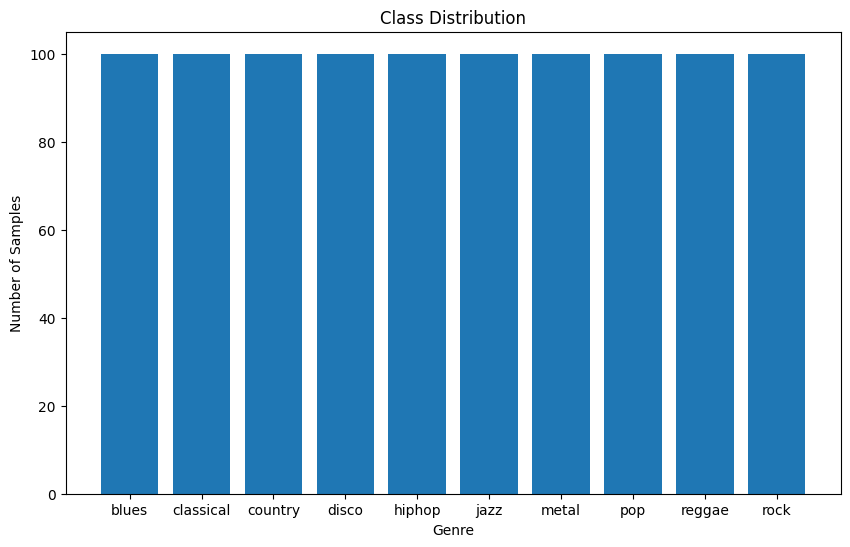

In [ ]:
# Plot the class distributions

# obtain the count for each category to use for the bar chart to examine the dataset balance
counts = list(category_counts.values())
plt.figure(figsize=(10, 6))
plt.bar(categories, counts)
plt.title('Class Distribution')
plt.xlabel('Genre')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
# defining the new path for the spectrogram images from the wav files
new_data_path = dataset_dirs[0]

In [ ]:
# Preprocessinge
# converting WAV to images

# function for plotting the spectrogram of the wav audio and save it
def plot_spectrogram(specgram, spectrogram_path_name):
    _, ax = plt.subplots(1, 1)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.axis('off')
    plt.savefig(spectrogram_path_name, bbox_inches='tight', pad_inches=0)

# create the new directory for the spectrograms if it doesn't exist yet
if not os.path.exists(new_data_path):
  print(f"Creating new directory: {new_data_path}")
  os.mkdir(new_data_path)

# go through each category folder of the wav file and generate their respective
# spectrogram
for category in os.listdir(dataset_path):
  print(f"Generating spectrogram for genre: {category}")
  genre_dir_path = f"{new_data_path}/{category}"

  if not os.path.exists(genre_dir_path):
    os.mkdir(genre_dir_path)

  for root_dir, directories, files in os.walk(os.path.join(dataset_path, category)):
    for music_file in files:
      music_file_path = os.path.join(root_dir, music_file)
      spectrogram_path_name = f"{genre_dir_path}/{music_file}.png"

      if not os.path.exists(spectrogram_path_name):
        try:
          # convert the audio file to wave and sample rate
          # create and save the figure of spectrogram
          SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(download_asset(music_file_path))
          spectrogram = T.Spectrogram(n_fft=600)
          spec = spectrogram(SPEECH_WAVEFORM)
          plt.figure(figsize=(6, 6))
          plot_spectrogram(spec[0], spectrogram_path_name)
          plt.close(fig="all")
        except:
          # knowing the only corrupt file is jazz jazz.00054.wav
          # we will convert jazz.00054.wav again just to augmentate corrupt file
          # and guarantee a fully balanced dataset
          print(f"Something went wrong while processing the following file: {music_file} will process the one before again for consistency")
          SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(download_asset(f"{root_dir}/jazz.00053.wav"))
          spectrogram = T.Spectrogram(n_fft=600)
          spec = spectrogram(SPEECH_WAVEFORM)
          plt.figure(figsize=(6, 6))
          plot_spectrogram(spec[0], f"{genre_dir_path}/jazz.00054.png")
          plt.close(fig="all")

Creating new directory: /content/drive/My Drive/GTZAN Genre Collection Spectrograms
Generating spectrogram for genre: blues
Generating spectrogram for genre: classical
Generating spectrogram for genre: country
Generating spectrogram for genre: disco
Generating spectrogram for genre: hiphop
Generating spectrogram for genre: jazz
Something went wrong while processing the following file: jazz.00054.wav will process the one before again for consistency
Generating spectrogram for genre: metal
Generating spectrogram for genre: pop
Generating spectrogram for genre: reggae
Generating spectrogram for genre: rock


In [ ]:
# Defining constants
TRAINING_SIZE = 0.8
TEST_SIZE = 1 - TRAINING_SIZE
NUM_EPOCHS = 25
# the resizing dimensions
DIM = (256, 256)
BATCH_SIZE = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cuda device


In [ ]:
# Split the dataset into train and test
# Hint: This is very similar to assignment 2

class GenreImageDataset(Dataset):
  def __init__(self, dataset_path: str, transforms=None):
    super(GenreImageDataset, self).__init__()
    # use the ImageFolder class to clasify images from the root folder and transform them
    self.dataset = ImageFolder(root=dataset_path, transform=transforms)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    return self.dataset[index]

# transformations: resizing, tensor, and normalize the images from [-1, 1]
image_transformation = transforms.Compose([transforms.Resize(DIM), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = GenreImageDataset(new_data_path, image_transformation)
train_size = int(TRAINING_SIZE * len(dataset))
test_size = len(dataset) - train_size
print(f"Dataset length: {len(dataset)}, train size (80%): {train_size}, test size (20%): {test_size}")

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

train_dataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataLoader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Dataset length: 1000, train size (80%): 800, test size (20%): 200
Number of training samples: 800
Number of test samples: 200


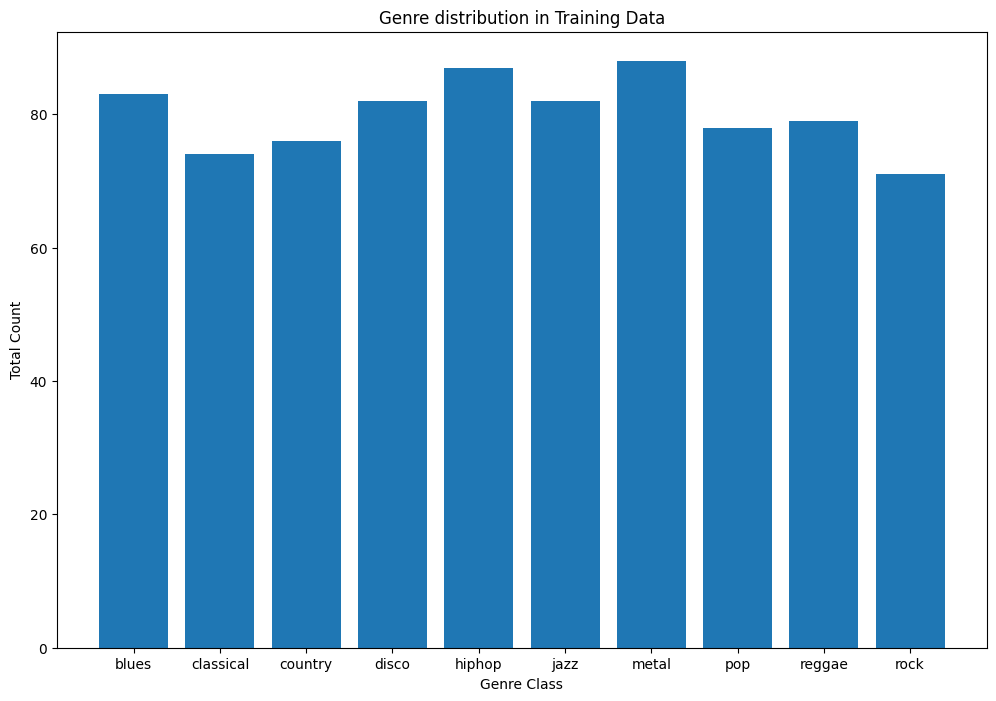

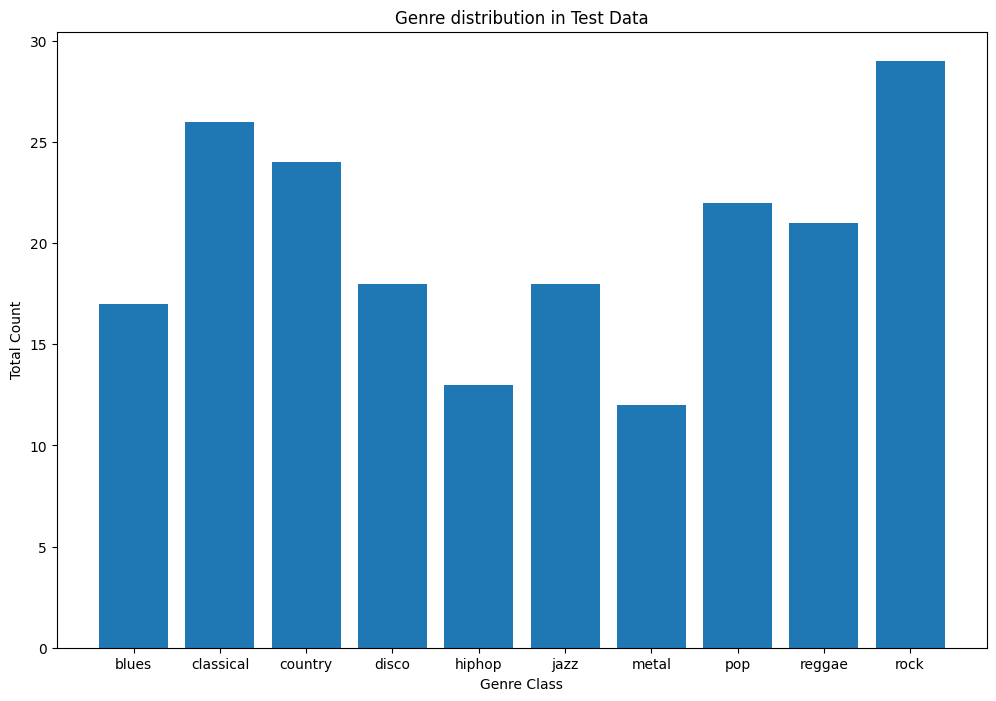

In [ ]:
# Any additional preproccessing

# Graphhing the distribution of the train and test set
train_tensor = torch.tensor([item[1] for item in train_dataset], dtype=torch.long)
test_tensor = torch.tensor([item[1] for item in test_dataset], dtype=torch.long)

train_emotion_counts = train_tensor.bincount()
plt.figure(figsize=(12, 8))
plt.bar(categories, train_emotion_counts)
plt.title('Genre distribution in Training Data')
plt.xlabel('Genre Class')
plt.ylabel('Total Count')
plt.show()

print()

test_emotion_count = test_tensor.bincount()
plt.figure(figsize=(12, 8))
plt.bar(categories, test_emotion_count)
plt.title('Genre distribution in Test Data')
plt.xlabel('Genre Class')
plt.ylabel('Total Count')
plt.show()

In [ ]:
# define the default learning rate and weight decay for both the proposed and pretrained model
learning_rate = 1e-3
weight_decay = 1e-4

# NOTE: the learning rate scheduling was taken from Anthony's Tutorial and was inspired to be used here
# It allowed the model to train more effeciently as it adjusted the learning rate to keep the loss at a minimum

# function for adjusting the learning rate per epoch
# it defines the half-cycle cosine decay schedule per step on each epoch
# it will adjust the learning rate during the training of the model to help the model coverage to a better minimum
def adjust_learning_rate(step, sched_config):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if step < sched_config["warmup_steps"]:
        lr = sched_config["max_lr"] * step / sched_config["warmup_steps"]
    else:
        lr = sched_config["min_lr"] + (
            sched_config["max_lr"] - sched_config["min_lr"]
        ) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (step - sched_config["warmup_steps"])
                / (sched_config["total_steps"] - sched_config["warmup_steps"])
            )
        )
    return lr

# obtain the learning rate from the optimizer
def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
# universal function for training a model per epoch. Generlized to take any loss function and optimizer
# for reusability purposes as both the proposed model and pretrained model will use the same training algorithm
def train_model_per_epoch(model, loss_function, optimizer):
  # initalize the parameters to use for adjusting the learning rate
  # step counter is the current epoch iteration step count
  # warmup step is used to maximize the learning rate and decrease it for the model per epoch
  step_counter = 0
  total_steps = len(train_dataLoader) * NUM_EPOCHS
  warmup_steps = int(total_steps*0.1)
  print(f"Total Steps: {total_steps}")
  print(f"Warmup Steps: {warmup_steps}")
  sched_config = {
      "max_lr": learning_rate,
      "min_lr": 0,
      "total_steps": total_steps,
      "warmup_steps": warmup_steps,
  }

  # ensures that cuda is available to allocate to gpu
  if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()

  # check if the for tensor memory allocation, whether it's to gpu or cpu
  model.train()
  for epoch in range(NUM_EPOCHS):
    print(f"Training Epoch {epoch+1}/{NUM_EPOCHS}")
    print("---------------------------")
    total_loss = 0.0
    for input, label in tqdm(train_dataLoader):
      # get learning rate according to the schedule
      new_learning_rate = adjust_learning_rate(
            step=step_counter, sched_config=sched_config
        )
      # update every parameter group with this new learning rate
      for g in optimizer.param_groups:
          g["lr"] = new_learning_rate
      input, label = input.to(device), label.to(device)
      optimizer.zero_grad()
      out = model(input)
      loss = loss_function(out, label)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      step_counter += 1

    current_lr = get_learning_rate(optimizer)
    print(f'Learning Rate: {current_lr:.4f}')

    print(f'Loss: {total_loss:.4f}')
    print()


# returns all labels and predicitions labels that are extracted from some data set
# for reusability purposes as the proposed model and pretrained model will use it
def evaluate_features(loader, model):
    if torch.cuda.is_available():
      model = model.cuda()
    features = []
    true_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            features_batch = model(inputs)
            _, feature_batch_t = torch.max(features_batch.data, 1)
            features.extend(feature_batch_t.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return features, true_labels


# utitlity function for creating the confusion matrix
# will take all the actual labels and predicted labels
# for reusability purposes as the proposed model and pretrained model will use it
def create_confusion_matrix(actual_labels, predicted_labels):
  cm = confusion_matrix(actual_labels, predicted_labels)

  plt.figure(figsize=(8,6))
  ax = sns.heatmap(cm, annot=True, fmt='d', )

  ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
  ax.set_ylabel("Actual", fontsize=14, labelpad=20)

  ax.xaxis.set_ticklabels(categories)
  ax.yaxis.set_ticklabels(categories)

  ax.set_title("Confusion Matrix for actual vs predicted images test", fontsize=14, pad=20)

  plt.show()

In [ ]:
# Define your model
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # use kernel 5 for large feature extraction, and padding 2 to keep the spatial dimension of the original image
    # for example, each convolutional layer will output the same spatial dimension it takes
    kernel_size = 5
    max_pool_kernel_size = kernel_size - 1
    padding = 2

    # convulational layers network for extracting the features of the spectrogram
    # goal was to maximize feature extraction while reducing the final out spatial size
    self.network = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=max_pool_kernel_size, stride=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=max_pool_kernel_size, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=max_pool_kernel_size, stride=2),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=kernel_size, padding=padding, stride=1),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(kernel_size=max_pool_kernel_size, stride=2),
        nn.AdaptiveAvgPool2d(output_size=(7, 7))
    )

    # obtain the classifier input size
    self.classifier_input_size = self._get_classifier_input_size()
    print(f"Classifier input size {self.classifier_input_size}")

    # classifies the output using linear layers
    self.classifier = nn.Sequential(
        nn.Linear(self.classifier_input_size, 120),
        nn.ReLU(),
        nn.Linear(120, 120),
        nn.ReLU(),
        nn.Linear(120, len(categories)),
    )

  def _get_classifier_input_size(self):
      # universal function using a sample input to obtain the input size for the classifier layer
      # useful to allow for editting the convolutional network and not have to manually calculate the output
      sample_input = torch.randn(BATCH_SIZE, 3, DIM[0], DIM[1])
      conv_output = self.network(sample_input)
      conv_output_size = conv_output.view(conv_output.size(0), -1).size(1)
      return conv_output_size

  def forward(self, x):
    x = self.network(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


In [ ]:
# Define your model continue
cnn_model2 = CNNModel()

Classifier input size 25088


In [ ]:
# Define your model continue
# uses CrossEntropyLoss for loss function and SGD with adjustable learning rate and weight decay
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model2.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_model_per_epoch(cnn_model2, loss_function, optimizer)

Total Steps: 2500
Warmup Steps: 250
Training Epoch 1/25
---------------------------


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Learning Rate: 0.0004
Loss: 220.3545

Training Epoch 2/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0008
Loss: 181.8495

Training Epoch 3/25
---------------------------


100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


Learning Rate: 0.0010
Loss: 147.6208

Training Epoch 4/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Learning Rate: 0.0010
Loss: 122.8704

Training Epoch 5/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


Learning Rate: 0.0010
Loss: 101.8931

Training Epoch 6/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Learning Rate: 0.0009
Loss: 86.9023

Training Epoch 7/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0009
Loss: 77.9676

Training Epoch 8/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0009
Loss: 65.4545

Training Epoch 9/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0008
Loss: 57.0133

Training Epoch 10/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0008
Loss: 49.4172

Training Epoch 11/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


Learning Rate: 0.0007
Loss: 37.3566

Training Epoch 12/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Learning Rate: 0.0006
Loss: 29.9359

Training Epoch 13/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


Learning Rate: 0.0006
Loss: 23.5884

Training Epoch 14/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0005
Loss: 19.6710

Training Epoch 15/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


Learning Rate: 0.0004
Loss: 15.6355

Training Epoch 16/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0003
Loss: 12.4838

Training Epoch 17/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0003
Loss: 11.0505

Training Epoch 18/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0002
Loss: 8.8772

Training Epoch 19/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0002
Loss: 8.0465

Training Epoch 20/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Learning Rate: 0.0001
Loss: 8.2876

Training Epoch 21/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0001
Loss: 7.3391

Training Epoch 22/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0000
Loss: 7.4263

Training Epoch 23/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0000
Loss: 7.0854

Training Epoch 24/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Learning Rate: 0.0000
Loss: 6.3709

Training Epoch 25/25
---------------------------


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]

Learning Rate: 0.0000
Loss: 6.6938



In [ ]:
# Define your model continue
# extract the training features using the train set and the test features using the test set
# these features and labels will be used to fit the svm and let the svm predict more using the extracted unseen data of the test set
train_features, train_labels = evaluate_features(train_dataLoader, cnn_model2)
test_features, test_labels = evaluate_features(test_dataLoader, cnn_model2)

100%|██████████| 25/25 [00:05<00:00,  4.90it/s]


In [ ]:
# Define your model continue
scaler = StandardScaler()

# convert the features and labels to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

test_features = np.array(test_features)
test_labels = np.array(test_labels)

# Reshape train_features and test_features to a 2D array that corresponds to their respective labels
# this is necessary as to fit and predict to the svm, it expects certain dimensions and match between the features and respective labels
train_features = train_features.reshape(len(train_labels), -1)
test_features = test_features.reshape(len(test_labels), -1)

# scale the features
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)


svm_classifier = SVC(kernel="rbf")

# Define the parameters to use for the grid search
param_grid = {
    'C': [0.1, 1, 5, 10],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
}

# Perform Grid Search CV using pytorch built in grid search algorithm
# it uses cross validation 10 for evaluating each combination of hyperparameters and determining the best score for accuracy
grid_search = GridSearchCV(svm_classifier, param_grid, cv=10, scoring='accuracy')

grid_search.fit(train_features, train_labels)

# Get the best parameters and best estimator to predict with
best_params = grid_search.best_params_
print(f"Best parameters through grid search: {best_params}")
best_estimator = grid_search.best_estimator_

test_predictions = best_estimator.predict(test_features)

# get the accuracy of the final result after the cnn model and svm model
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy is {accuracy*100:.2f}%")

Best parameters through grid search: {'C': 0.1, 'gamma': 1}
Accuracy is 82.00%


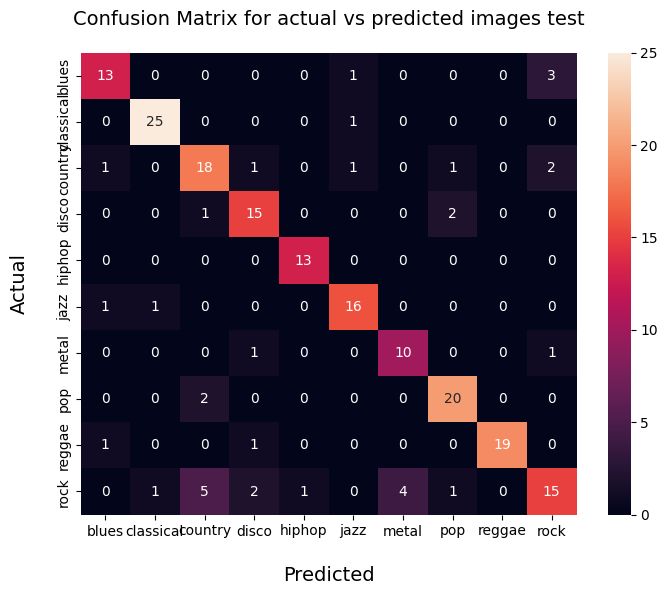

In [ ]:
# Compute and plot the confusion matrix
create_confusion_matrix(test_labels, test_predictions)

# pretrained model comparison using VG19

In [ ]:
# Pretrained models and pretrained weights
import torchvision.models as models


In [ ]:
# Define the pretrained model

# pretrained model defined with the default weights
weights = models.VGG19_Weights.DEFAULT
vgg19_model = models.vgg19(weights=weights)

# slightly tweaked on the last classifier to change it's classifer output from 1000 features to the number of features of the assignment (10)
vgg19_model.classifier[-1] = torch.nn.Linear(4096, len(categories))

print(vgg19_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 83.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# defining the loss function, optimizer and Train it
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train_model_per_epoch(vgg19_model, loss_function, optimizer)

Total Steps: 2500
Warmup Steps: 250
Training Epoch 1/25
---------------------------


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


Learning Rate: 0.0004
Loss: 231.6040

Training Epoch 2/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Learning Rate: 0.0008
Loss: 219.6742

Training Epoch 3/25
---------------------------


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Learning Rate: 0.0010
Loss: 185.2634

Training Epoch 4/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Learning Rate: 0.0010
Loss: 149.8785

Training Epoch 5/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Learning Rate: 0.0010
Loss: 127.2346

Training Epoch 6/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Learning Rate: 0.0009
Loss: 108.6377

Training Epoch 7/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Learning Rate: 0.0009
Loss: 101.3484

Training Epoch 8/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Learning Rate: 0.0009
Loss: 85.3242

Training Epoch 9/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Learning Rate: 0.0008
Loss: 74.8536

Training Epoch 10/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


Learning Rate: 0.0008
Loss: 64.8347

Training Epoch 11/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.03it/s]


Learning Rate: 0.0007
Loss: 58.4795

Training Epoch 12/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Learning Rate: 0.0006
Loss: 50.3387

Training Epoch 13/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Learning Rate: 0.0006
Loss: 43.1544

Training Epoch 14/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Learning Rate: 0.0005
Loss: 37.2205

Training Epoch 15/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Learning Rate: 0.0004
Loss: 31.5925

Training Epoch 16/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Learning Rate: 0.0003
Loss: 27.8786

Training Epoch 17/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Learning Rate: 0.0003
Loss: 25.6992

Training Epoch 18/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


Learning Rate: 0.0002
Loss: 19.6721

Training Epoch 19/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Learning Rate: 0.0002
Loss: 17.0707

Training Epoch 20/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Learning Rate: 0.0001
Loss: 14.7061

Training Epoch 21/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


Learning Rate: 0.0001
Loss: 13.3566

Training Epoch 22/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Learning Rate: 0.0000
Loss: 13.3784

Training Epoch 23/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Learning Rate: 0.0000
Loss: 11.8108

Training Epoch 24/25
---------------------------


100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


Learning Rate: 0.0000
Loss: 10.0124

Training Epoch 25/25
---------------------------


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]

Learning Rate: 0.0000
Loss: 11.7734



In [ ]:
# Test the model using the same chosen metric as your own model
predicted_labels, actual_labels = evaluate_features(test_dataLoader, vgg19_model)
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Accuracy is {accuracy*100:.2f}%")

100%|██████████| 25/25 [00:05<00:00,  4.81it/s]

Accuracy is 78.50%


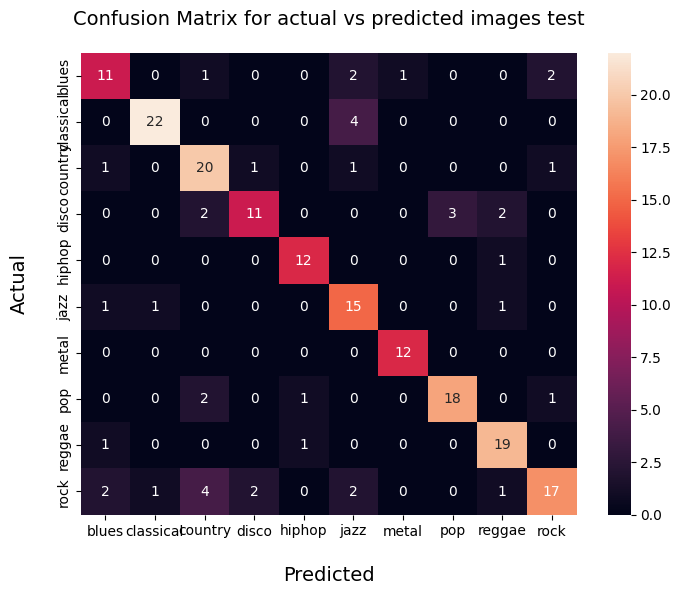

In [ ]:
# Compute and plot the confusion matrix
create_confusion_matrix(actual_labels, predicted_labels)